# Administrative



# RNN
<img src="rnn-0.png">
<img src="rnn-1.png">
<img src="rnn-2.png">
<img src="cs-0.png">
<img src="cs-1.png">
<img src="cs-2.png">
<img src="cs-3.png">
http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture10.pdf


# LSTM
<img src="rnn-3.png">
<img src="rnn-4.png">
<img src="rnn-5.png">
<img src="rnn-6.png">
<img src="rnn-7.png">
<img src="rnn-8.png">

<img src="rnn-12.png" width=1000px>

## Gradient:
<img src="vanish.gif" width="750" align="center">

# GRU
GRU.png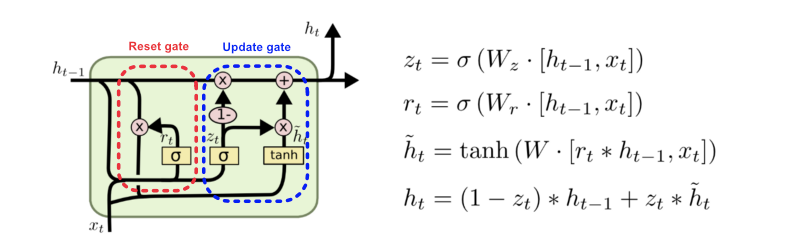

<img src="rnn-9.png">
<img src="rnn-10.png">
<img src="rnn-11.png">

## read: https://danijar.com/tips-for-training-recurrent-neural-networks/

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
 
'''
STEP 1: LOADING DATASET
'''
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
 
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())
 
'''
STEP 2: MAKING DATASET ITERABLE
'''
 
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
 
'''
STEP 3: CREATE MODEL CLASS
'''
 
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
         
        # Number of hidden layers
        self.layer_dim = layer_dim
         
        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        #[b_ig | b_fg | b_gg | b_og]
        #print(self.lstm._all_weights) [['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0'], 
        #['weight_ih_l1', 'weight_hh_l1', 'bias_ih_l1', 'bias_hh_l1'], 
        #['weight_ih_l2', 'weight_hh_l2', 'bias_ih_l2', 'bias_hh_l2']]
        for names in self.lstm._all_weights:
            for name in filter(lambda n: "bias" in n,  names):
                bias = getattr(self.lstm, name)
                n = bias.size(0)
                start, end = n//4, n//2
                bias.data[start:end].fill_(1.)
                
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
     
    def forward(self, x):
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        
        #print(x.shape,"x.shape")100, 28, 28
        if torch.cuda.is_available():
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda()
        else:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
         
        # Initialize cell state
        if torch.cuda.is_available():
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda()
        else:
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        
        #Note you can also learn the h0 and c0!
        
        out, (hn, cn) = self.lstm(x, (h0,c0))#or None!

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10

        return out
 
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28
hidden_dim = 100
layer_dim = 3  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 10
 
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
 
#######################
#  USE GPU FOR MODEL  #
#######################
 
if torch.cuda.is_available():
    model.cuda()
     
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()
 
'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1
 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
 
'''
STEP 7: TRAIN THE MODEL
'''
 
# Number of steps to unroll
seq_dim = 28 
 
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            images = images.view(-1, seq_dim, input_dim).cuda()
            labels = labels.cuda()
        else:
            images = images.view(-1, seq_dim, input_dim)

             
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
         
        iter += 1
         
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = images.view(-1, seq_dim, input_dim).cuda()

                 
                # Forward pass only to get logits/output
                outputs = model(images)
                 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                 
                # Total number of labels
                total += labels.size(0)
                 
                # Total correct predictions
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
             
            accuracy = 100 * correct / total
             
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.434834182262. Accuracy: 84
Iteration: 1000. Loss: 0.136468246579. Accuracy: 93
Iteration: 1500. Loss: 0.120171070099. Accuracy: 95
Iteration: 2000. Loss: 0.100983522832. Accuracy: 96
Iteration: 2500. Loss: 0.0771686136723. Accuracy: 96
Iteration: 3000. Loss: 0.0426399931312. Accuracy: 97
Iteration: 3500. Loss: 0.119539186358. Accuracy: 97
Iteration: 4000. Loss: 0.138467758894. Accuracy: 97
Iteration: 4500. Loss: 0.144654884934. Accuracy: 97
Iteration: 5000. Loss: 0.0106083443388. Accuracy: 97
Iteration: 5500. Loss: 0.02268467471. Accuracy: 98
Iteration: 6000. Loss: 0.0111944293603. Accuracy: 98


# Assignment7
- Rewrite the MNIST LSTM code using your own LSTM layer (Don't use nn.LSTM or nn.LSTMCell!)
- Extra point to write MNIST GRU code using your own GRU layer (Don't use nn.GRU or nn.GRUCell!)

## Refrences:
### CS231n Standford
### https://colah.github.io/posts/2015-08-Understanding-LSTMs/
### https://www.udemy.com/course/practical-deep-learning-with-pytorch/
### https://imgur.com/gallery/vaNahKE
### https://gdcoder.com/what-is-a-recurrent-neural-networks-rnns-and-gated-recurrent-unit-grus/